## Autoencoder model
Below there is an implementation of the class, that will obtain loss from output of decoder and from latent space as well.

In [0]:
# imports
import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython import display

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as torch_data

#### Autoencoder class

Note that output is tuple: (latent output, decoder output)

In [0]:
class AE_model(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE_model, self).__init__()
        # encoder and decoder could be of any architecture
        self.encoder = encoder 
        self.decoder = decoder
    
    def forward(self, x, num_components=100):
        """
        Here we take image and return 3 tensors:
        (first num_components of latent representation,
        last n-num_components of latent representation,
        decoder output)

        :param x: torch.tensor, (batch_size, x_dim)
        :return: torch.tensor, (batch_size, x_dim)
        """
        x_latent = self.encoder(x)
        x_out = self.decoder(x_latent)
        return (x_latent[:, :num_components], x_latent[:, num_components:], x_out)

#### Some encoder-decoder architectures.

In [0]:
class View(torch.nn.Module):
    def __init__(self, out_shape):
        super().__init__()
        self.out_shape = out_shape
    def forward(self, input):
        return input.view(*self.out_shape)

encoder = lambda bottle_dim: nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=5, kernel_size=7), 
    torch.nn.BatchNorm2d(5), torch.nn.ReLU(), # (5, 22, 22)
    torch.nn.MaxPool2d(kernel_size=2, stride=2), 
    torch.nn.BatchNorm2d(5), torch.nn.Dropout(p=0.02), # (5, 11, 11)
    torch.nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3), 
    torch.nn.BatchNorm2d(3), torch.nn.ReLU(), # (3, 9, 9) 
    torch.nn.Flatten(), # (3*9*9)
    torch.nn.Linear(3*9*9, bottle_dim), torch.nn.Tanh()
    ) 

decoder = lambda bottle_dim: nn.Sequential( 
    torch.nn.Linear(bottle_dim, 3*9*9), View(out_shape=(-1, 3, 9, 9)),
    torch.nn.ConvTranspose2d(in_channels=3, out_channels=5, kernel_size=3), 
    torch.nn.BatchNorm2d(5), torch.nn.ReLU(), torch.nn.Dropout(p=0.02), # (5, 11, 11)
    torch.nn.ConvTranspose2d(in_channels=5, out_channels=5, kernel_size=12), torch.nn.BatchNorm2d(5), torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(in_channels=5, out_channels=1, kernel_size=7), torch.nn.Sigmoid()
    ) 

#### Train function
Note that it takes into account the fact, that model output is tuple.
Also the whole batch should be **of the same class**.

In [0]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader, 
          num_latent_clean=100, 
          scheduler=None, verbose=True, save_dir=None, baseline=None, device='cuda'):
    net.to(device)
    train_losses = []
    val_losses = []
    latent_first_losses = []
    latent_last_losses = []

    epoch_list = []

    freq = max(epochs//100, 1)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = []

        for X_train, y_train in train_loader:

            X_train = X_train.to(device)
            # Perform one step of minibatch stochastic gradient descent
            net_latent_first, net_latent_last, net_output = net.forward(X_train, num_latent_clean)
            loss_out = criterion(net_output, X_train)
            if y_train[0] == 0: # clean image
                loss_latent = criterion(net_latent_last, 
                                        torch.zeros(size=(X_train.shape[0], net_latent_last.shape[1]), device=device))

                loss = loss_out + loss_latent
            elif y_train[0] == 1: # noisy image
                loss = loss_out
            elif y_train[0] == 2: # noise only
                loss_latent = criterion(net_latent_first, 
                                        torch.zeros(size=(X_train.shape[0], net_latent_first.shape[1]), device=device))

                loss = loss_out + loss_latent
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        train_losses.append( np.mean(train_loss) )


        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X_val, _ in val_loader:
            # Compute the validation loss
            X_val = X_val.to(device)
            net_output = net.forward(X_val)[2]
            val_loss = criterion(net_output, X_val)

        val_losses.append( val_loss )
        epoch_list.append(epoch)

        if scheduler is not None:
            scheduler.step()
        
        if verbose and epoch%freq==0:
            
            display.clear_output(wait=True)
            f, axes = plt.subplots(1, 1, figsize=(8, 6))
            axes.set_title('Loss', fontsize=20)
            axes.plot(epoch_list, train_losses, label='train')
            axes.plot(epoch_list, val_losses, label='val')
            axes.set_xlabel('epoch', fontsize=15)
            axes.set_ylabel('MSE', fontsize=15)
            axes.grid(True)
            if baseline:
                axes.axhline(baseline, c='r', label='baseline')

            axes.legend(fontsize=15)
            plt.tight_layout()
            plt.show()

### Dataset
Here is MNIST, which has 10 classes, but we will select 2.


In [0]:
train_data = pd.read_csv('sample_data/mnist_train_small.csv', header=None)
test_data = pd.read_csv('sample_data/mnist_test.csv', header=None)

In [0]:
train_data = train_data.sort_values(by=[0])

In [0]:
train_mask = train_data[0].isin([0,1,2])
X_train = train_data[train_mask].drop(0, axis=1).reset_index(drop=True)
y_train = train_data[train_mask][0].reset_index(drop=True)

test_mask = test_data[0].isin([0,1,2])
X_test = test_data[test_mask].drop(0, axis=1).reset_index(drop=True)
y_test = test_data[test_mask][0].reset_index(drop=True)

In [0]:
X_train = X_train.values.reshape(len(X_train), 1, 28, 28)
y_train = y_train.values

X_test = X_test.values.reshape(len(X_test), 1, 28, 28)
y_test = y_test.values

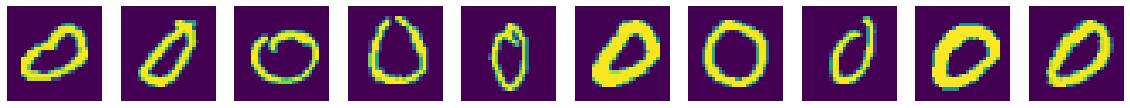

In [115]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(np.array(X_train[i]).reshape(28,28));
    ax[i].axis('off')

In [116]:
class mnist(torch_data.Dataset):
    def __init__(self, X, y):
        super(mnist, self).__init__()
        self.X = torch.FloatTensor(np.array(X/255))
        self.y = torch.FloatTensor(np.array(y))


    def __len__(self):
        return self.X.shape[0]


    def __getitem__(self, idx):
        return ([self.X[idx], self.y[idx]])

train_dset = mnist(X_train, y_train) 
test_dset = mnist(X_test, y_test) 

print(train_dset[5][0].shape)

torch.Size([1, 28, 28])


### Train initialization.

In [117]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

net = AE_model(encoder(30), decoder(30)) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) 

device: cuda


In [0]:
train_loader = torch_data.DataLoader(train_dset, batch_size=20, shuffle=False)
val_loader = torch_data.DataLoader(test_dset, batch_size=100, shuffle=False)

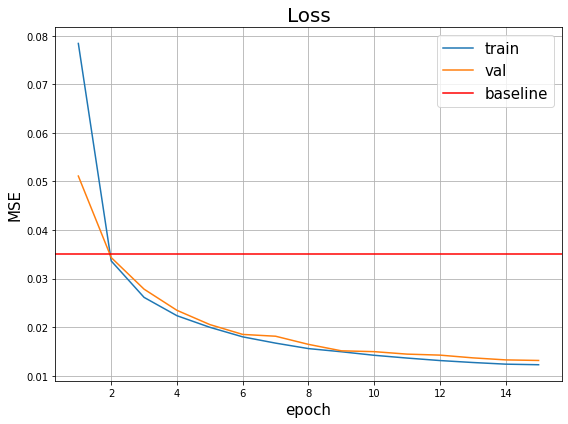

In [119]:
epochs = 15
train(epochs, net, criterion, optimizer, train_loader, val_loader, num_latent_clean=10, 
      scheduler=scheduler, verbose=True, baseline=0.035)

### Latent visualization

Here we do PCA on 10-dimensional latent representation.

In [0]:
### BEGIN Solution

test_latent_30D = np.empty((0, 30), dtype=float)

for X_all_batch, _ in val_loader:
    X_all_batch = X_all_batch.to(device)
    X_all_batch_latent = net(X_all_batch)[0]
    test_latent_30D = np.append(test_latent_30D, X_all_batch_latent.detach().cpu(), axis=0)

### END Solution

In [0]:
pca = PCA(n_components=3)
test_latent_3D = pca.fit_transform(test_latent_30D)

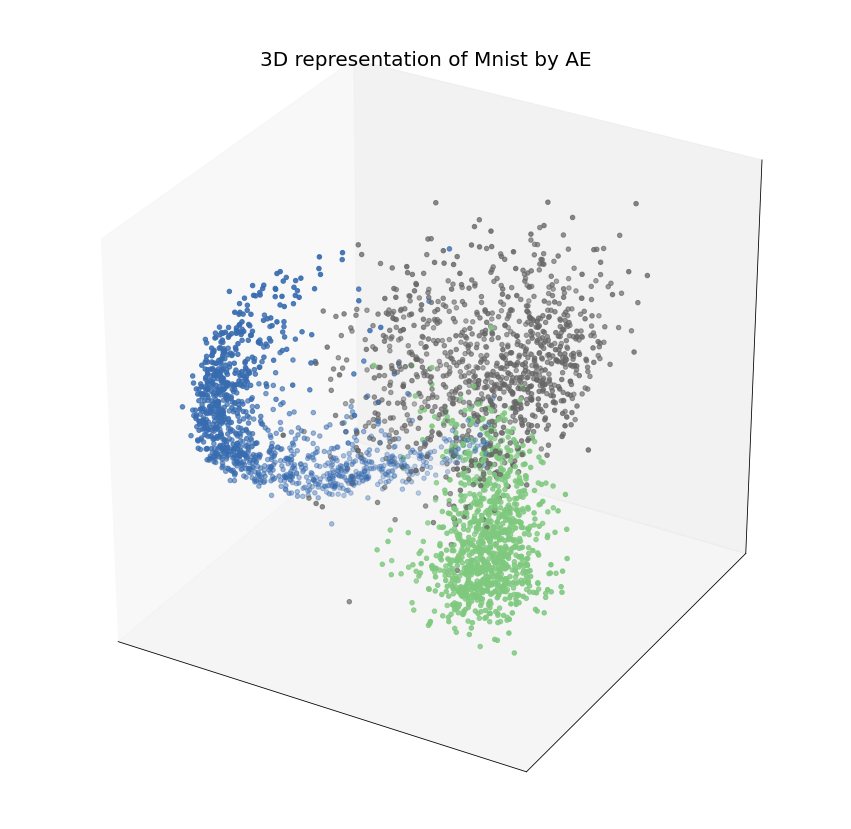

In [123]:
# plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

ax1.scatter(test_latent_3D[:, 0], test_latent_3D[:, 1], test_latent_3D[:, 2], c=y_test, cmap='Accent')
_ = ax1.set_xticks([])
_ = ax1.set_yticks([])
_ = ax1.set_zticks([])

_ = ax1.set_title('3D representation of Mnist by AE', fontsize=20)